# Text mining: Predir el preu



In [ ]:
import pandas as pd
import requests, io
import numpy as np
import seaborn as sns

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Read Data

In [ ]:
data = pd.read_csv('https://github.com/paubernabe/data/blob/main/juliol.csv?raw=true')
print(data.shape)
data.head(5)

(17079, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210707180233,2021-07-07,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia And Maria,2010-01-19,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,98%,81%,f,https://a0.muscache.com/im/users/71615/profile...,https://a0.muscache.com/im/users/71615/profile...,la Sagrada Família,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire apartment,Entire home/apt,8,NaN,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",$169.00,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,60,2021-07-07,21,0,0,2014-03-02,2019-10-11,4.40,4.55,4.75,4.80,4.90,4.75,4.30,HUTB-002062,t,18,18,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210707180233,2021-07-08,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,Etain (Marnie),2010-03-09,"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within a few hours,100%,67%,f,https://a0.muscache.com/im/users/90417/profile...,https://a0.muscache.com/im/users/90417/profile...,El Besòs i el Maresme,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire apartment,Entire home/apt,6,NaN,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",$240.00,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,NaN,t,17,47,77,169,2021-07-08,52,0,0,2016-01-05,2019-12-15,4.74,4.92,4.92,4.94,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.78
2,32711,https://www.airbnb.com/rooms/32711,20210707180233,2021-07-08,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,Nick,2010-05-31,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within a day,83%,100%,f,https://a0.muscache.com/im/users/135703/profil...,https://a0.muscache.com/im/users/135703/profil...,Camp d'en Grassot i Gràcia Nova,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.40566,2.1

In [ ]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

## Clean data

In [ ]:
'''
S'eliminen identificadors i dades que no tenen rellevància
'''
data = data.drop(['scrape_id', 'last_scraped', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                  'host_neighbourhood', 'calendar_updated'],axis=1)

In [ ]:
'''
Eliminem els caràcters no desitjats en els camps
'''
def clean_str(x):
    if (type(x) == str):
      x = x.replace("$", "").replace(",", "").replace(" ", "").replace("%", "")
    return float(x)



d = {'t': True, 'f': False}
data['host_has_profile_pic'] = data['host_has_profile_pic'].map(d)
data['host_is_superhost'] = data['host_is_superhost'].map(d)  
data['host_identity_verified'] = data['host_identity_verified'].map(d)
data['has_availability'] = data['has_availability'].map(d)
data['instant_bookable'] = data['instant_bookable'].map(d)

data['price'] = data['price'].apply(clean_str)
data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(clean_str)
data['host_response_rate'] = data['host_response_rate'].apply(clean_str)

### Distància al centre

La fórmula del semiversinus o fórmula del haversine és una important equació per a la navegació astronòmica, pel que fa al càlcul de la distància de cercle màxim entre dos punts d'un globus sabent la seva longitud i la seva latitud.

En aquesta funció es calcula la distància que hi ha de cada apartament al centre. Definim **com a centre** de Barcelona, la Plaça de Catalunya.

In [ ]:
def haversine_distance(lat1, lon1):
   r = 6371
   lat2 = 41.3870154 #pl catalunya
   lon2 = 2.1700471
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [ ]:
data['distance'] = data.apply(lambda row : haversine_distance(row['latitude'],
                                  row['longitude']), axis = 1)

In [ ]:
def bar_plot_object(title,data):
  x = list(data.value_counts().keys())
  x = x[::-1]
  y = list(data.value_counts())
  y = y[::-1]
  plt.barh(x,y)
  plt.title(title)
  return None


def explore_col(data, column):
  bar_plot_object(column+" histogram",data[column])
  print(column,'description\n', data[column].describe())
  print('Top 5 frequent:',data[column].value_counts()[:5].index.tolist())


### Data engineering

- Dealing with NaN

In [ ]:
for c in data.columns:
  na = data[c].isnull().sum()
  if na > 0:
    print(c, na)
    if na > 1000:
      del data[c]

name 10
description 132
neighborhood_overview 6678
host_since 49
host_response_time 4746
host_response_rate 4746
host_acceptance_rate 5243
host_is_superhost 49
host_listings_count 49
host_total_listings_count 49
host_has_profile_pic 49
host_identity_verified 49
neighbourhood 6678
bathrooms 17079
bathrooms_text 20
bedrooms 575
beds 341
minimum_minimum_nights 1
maximum_minimum_nights 1
minimum_maximum_nights 1
maximum_maximum_nights 1
minimum_nights_avg_ntm 1
maximum_nights_avg_ntm 1
first_review 5095
last_review 5095
review_scores_rating 5095
review_scores_accuracy 5292
review_scores_cleanliness 5289
review_scores_checkin 5295
review_scores_communication 5290
review_scores_location 5296
review_scores_value 5297
license 6428
reviews_per_month 5095


In [ ]:
for c in data.columns:
  na = data[c].isnull().sum()
  if na > 0:
    print(c, na)

name 10
description 132
host_since 49
host_is_superhost 49
host_listings_count 49
host_total_listings_count 49
host_has_profile_pic 49
host_identity_verified 49
bathrooms_text 20
bedrooms 575
beds 341
minimum_minimum_nights 1
maximum_minimum_nights 1
minimum_maximum_nights 1
maximum_maximum_nights 1
minimum_nights_avg_ntm 1
maximum_nights_avg_ntm 1


In [ ]:
#data['reviews_scores_rating'] = data['review_scores_rating'].fillna(data['review_scores_rating'].mean())

- Dummy variables


In [ ]:
#new categorical columns
y = pd.get_dummies(data.room_type, prefix='rt')
type(y)
data = data.join(y)

y = pd.get_dummies(data.property_type, prefix='property')
type(y)
data = data.join(y)

y = pd.get_dummies(data.host_is_superhost, prefix='superhost')
type(y)
data = data.join(y)

y = pd.get_dummies(data.neighbourhood_group_cleansed, prefix='nb')
type(y)
data = data.join(y)

y = pd.get_dummies(data.instant_bookable, prefix='ib')
type(y)
data = data.join(y)


- Outliers

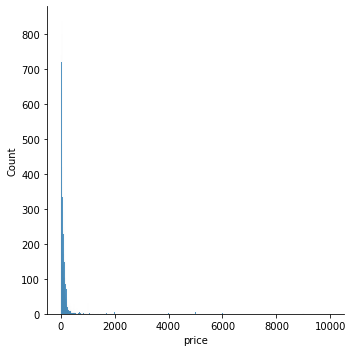

In [ ]:
sns.displot(data, x="price", binwidth=3)

In [ ]:
print(data['price'].min(), data['price'].max(), data['price'].mean())

0.0 9999.0 115.01399379354763


In [ ]:
print(len(data[data['price'] > 350]))

542


In [ ]:
print(len(data[data['price'] < 10]))

48


In [ ]:
data = data[data['price'] < 350]

In [ ]:
data = data[data['price'] > 10]

In [ ]:
print(data['price'].min(), data['price'].max(), data['price'].mean())

11.0 349.0 89.21699720160603


- Nombre d'amenities que té l'apartament

In [ ]:
import ast
def len_amenities(x):

  return len(ast.literal_eval(x))


data['amenities_len'] = data['amenities'].apply(len_amenities)

### Lavabos

Els lavabos són una part rellevant de l'apartament, però en les dades la columna de nombre de lavabos és tota nul·la.
No obstant això, es pot agafar la informació de la columna 'bathroom-text'.



In [ ]:
#data['bathrooms'].isna().sum()

In [ ]:
data['bathrooms_text'].value_counts()

1 bath               6404
1 shared bath        3587
2 baths              2585
1 private bath       1155
1.5 shared baths      773
1.5 baths             717
2 shared baths        572
3 baths               162
2.5 baths             100
2.5 shared baths       68
3 shared baths         54
0 shared baths         37
4 baths                32
Shared half-bath       31
3.5 baths              26
Half-bath              23
0 baths                22
11 shared baths        14
3.5 shared baths       14
5 baths                10
5.5 baths              10
4 shared baths         10
Private half-bath       5
7 shared baths          3
6 baths                 2
5 shared baths          2
4.5 shared baths        2
7.5 shared baths        1
7.5 baths               1
Name: bathrooms_text, dtype: int64

Es creen dues noves categories: lavabo privat i lavabo compartit.

In [ ]:
import re

def parse_bathroom_shared(x):
  if type(x) == str:
    if 'shared' in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        #return float('nan')
        return 1
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0

def parse_bathroom(x):
  if type(x) == str:
    if 'shared' not in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        #return float('nan')
        return 1
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0
  

data['private_bath'] = data['bathrooms_text'].apply(parse_bathroom)
data['shared_bath'] = data['bathrooms_text'].apply(parse_bathroom_shared)
#del data['bathrooms']

In [ ]:
data['private_bath'].value_counts()

1.0    7587
0.0    5206
2.0    2585
1.5     717
3.0     162
2.5     100
4.0      32
3.5      26
5.0      10
5.5      10
6.0       2
7.5       1
Name: private_bath, dtype: int64

In [ ]:
data['shared_bath'].value_counts()

0.0     11307
1.0      3618
1.5       773
2.0       572
2.5        68
3.0        54
11.0       14
3.5        14
4.0        10
7.0         3
5.0         2
4.5         2
7.5         1
Name: shared_bath, dtype: int64

In [ ]:
data.head()['distance']

0    2.07
1    5.11
2    2.07
3    0.83
4    0.96
Name: distance, dtype: float64

## Transports i serveis

S'utilitzen dos conjunts de dades de la web https://opendata-ajuntament.barcelona.cat/es/ que ens donen informació sobre el transport(metro, rodalies, etc) i els serveis (bars i restaurants) que hi han a cada districte.

In [ ]:
transport = pd.read_csv('https://github.com/paubernabe/data/blob/main/TRANSPORTS.csv?raw=true')
print(transport.shape)
transport.head(5)

(642, 16)


,CODI_CAPA,CAPA_GENERICA,NOM_CAPA,ED50_COORD_X,ED50_COORD_Y,ETRS89_COORD_X,ETRS89_COORD_Y,LONGITUD,LATITUD,EQUIPAMENT,DISTRICTE,BARRI,NOM_DISTRICTE,NOM_BARRI,ADRECA,TELEFON
0,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,428480.365,4586484.614,428388.453,4586283.641,2.142987,41.424923,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",7.0,41.0,Horta-Guinardó,la Vall d'Hebron,NaN,NaN
1,K002,Transports i serveis relacionats,Ferrocarrils Generalitat (FGC),429726.943,4582853.670,429635.018,4582652.730,2.158326,41.392331,FGC - PROVENÇA (C. de Provença)-,2.0,8.0,Eixample,l'Antiga Esquerra de l'Eixample,NaN,NaN
2,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,426477.889,4583649.008,426385.994,4583448.062,2.119370,41.399203,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,5.0,23.0,Sarrià-Sant Gervasi,Sarrià,NaN,NaN
3,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,427818.595,4583478.761,427726.688,4583277.816,2.135427,41.397791,FGC (L6) - LA BONANOVA-,5.0,26.0,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,NaN,NaN
4,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,432051.444,4589400.176,431959.500,4589199.175,2.185391,41.451492,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,8.0,53.0,Nou Barris,la Trinitat Nova,NaN,NaN


El que es fa és sumar el nombre de serveis que pertanyen a un districte en concret. Amb el transport es fa el mateix.

In [ ]:
tr = transport['NOM_DISTRICTE'].value_counts()

numtransp = pd.DataFrame([tr]).T
numtransp =numtransp.reset_index()
numtransp.columns = ['name', 'number']
numtransp

,name,number
0,Eixample,120
1,Sant Martí,70
2,Sarrià-Sant Gervasi,57
3,Sants-Montjuïc,53
4,Sant Andreu,40
5,Nou Barris,39
6,Horta-Guinardó,31
7,Ciutat Vella,27
8,Les Corts,24
9,Gràcia,17


In [ ]:
def transport_num(x):
  if type(x) == str:
    tmp = numtransp.loc[numtransp['name'] == x]
    return tmp['number'].values[0]
  return 0

data['transport'] = data['neighbourhood_group_cleansed'].apply(transport_num)

In [ ]:
restaurants = pd.read_csv('https://github.com/paubernabe/data/blob/main/rest.csv?raw=true')
print(restaurants.shape)
restaurants.head(5)

(2504, 36)


,register_id,name,institution_id,institution_name,created,modified,addresses_roadtype_id,addresses_roadtype_name,addresses_road_id,addresses_road_name,addresses_start_street_number,addresses_end_street_number,addresses_neighborhood_id,addresses_neighborhood_name,addresses_district_id,addresses_district_name,addresses_zip_code,addresses_town,addresses_main_address,addresses_type,values_id,values_attribute_id,values_category,values_attribute_name,values_value,values_outstanding,values_description,secondary_filters_id,secondary_filters_name,secondary_filters_fullpath,secondary_filters_tree,secondary_filters_asia_id,geo_epgs_25831_x,geo_epgs_25831_y,geo_epgs_4326_x,geo_epgs_4326_y
0,﻿2122182514,Restaurant Chido One,NaN,NaN,2002-05-02T00:00:00+02:00,2021-03-03T22:14:06.509761+01:00,NaN,NaN,341908,C Torrijos,30.0,NaN,31,la Vila de Gràcia,6,Gràcia,8012,BARCELONA,True,NaN,134757.0,20001.0,Telèfons,Tel.,932850335,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429706.567847,4.583870e+06,41.403301,2.159041
1,﻿2064171550,Labona Pizza *Gal·lileu,NaN,NaN,2002-03-05T00:00:00+01:00,2021-07-21T12:29:38.986716+02:00,NaN,NaN,138802,Carrer de Galileu,326.0,NaN,19,les Corts,4,Les Corts,8028,Barcelona,True,NaN,134615.0,20001.0,Telèfons,Tel.,933222040,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,427366.054990,4.581993e+06,41.386187,2.131268
2,﻿99400276550,Restaurant Pez Vela Chiringuito,NaN,NaN,2011-09-02T12:07:02+02:00,2021-03-03T22:14:28.487962+01:00,NaN,NaN,701644,Pg Mare Nostrum,19.0,NaN,3,la Barceloneta,1,Ciutat Vella,8039,BARCELONA,True,NaN,224661.0,20001.0,Telèfons,Tel.,932216317,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432247.321931,4.580054e+06,41.369151,2.189861
3,﻿99400264196,Restaurant Udon *Glòries,NaN,NaN,2011-02-07T00:00:00+01:00,2021-03-03T22:14:49.237116+01:00,NaN,NaN,144601,Av Diagonal,208.0,NaN,66,el Parc i la Llacuna del Poblenou,10,Sant Martí,8018,BARCELONA,True,NaN,223254.0,20001.0,Telèfons,Tel.,934861314,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432506.888609,4.584029e+06,41.404976,2.192521
4,﻿75990341919,Bar Restaurant Marcelino 16 *Diputació,NaN,NaN,1996-09-18T00:00:00+02:00,2021-03-03T22:14:35.713828+01:00,NaN,NaN,100800,C Diputació,41.0,NaN,9,la Nova Esquerra de l'Eixample,2,Eixample,8015,BARCELONA,True,NaN,149688.0,20001.0,Telèfons,Tel.,934246267,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429109.288208,4.581221e+06,41.379388,2.152206


In [ ]:
tr = restaurants['addresses_district_name'].value_counts()

rest = pd.DataFrame([tr]).T
rest =rest.reset_index()
rest.columns = ['name', 'number']
rest

,name,number
0,Eixample,846
1,Ciutat Vella,558
2,Sarrià-Sant Gervasi,273
3,Sant Martí,198
4,Gràcia,191
5,Sants-Montjuïc,189
6,Les Corts,115
7,Sant Andreu,63
8,Horta-Guinardó,46
9,Nou Barris,25


In [ ]:
def restaurants_num(x):
  if type(x) == str:
    tmp = rest.loc[rest['name'] == x]
    if tmp.empty:
      return 0
    return tmp['number'].values[0]
  return 0

data['restaurants'] = data['neighbourhood_group_cleansed'].apply(restaurants_num)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

english_stop = stopwords.words('english')
spanish_stop = stopwords.words('spanish')

stop = english_stop + spanish_stop

data = data[data['amenities'].notna()]
data = data[data['name'].notna()]
data = data[data['description'].notna()]


print(data.shape)
def clean_text(x):

    '''#will replace the html characters with " "
    text=re.sub('<.*?>', ' ', x)
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will split and join the words
    #text=' '.join(text.split())'''

    x = re.sub('<.*?>', ' ', x)
    x = re.sub(r'\w*\d\w*', '', x)
    x = x.translate(str.maketrans(' ',' ',string.punctuation))
    x = re.sub("\n"," ",x)
    x = x.lower()
    
    t = ''
    for word in x.split():
      if word not in stop and not word.isdigit() and word.isalpha():
        t += ' ' + word
    return t

data['amenities'] = data['amenities'].apply(clean_text)
data['name'] = data['name'].apply(clean_text)
data['description'] = data['description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(16308, 127)


TF IDF AMENITIES

In [ ]:
v = TfidfVectorizer(max_df=0.9, min_df=0.1)
x = v.fit_transform(data['amenities'])

dfw = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dfw

,aid,air,alarm,balcony,basics,bed,bedroom,blankets,cable,carbon,chair,coffee,conditioning,cooking,crib,dedicated,dishes,dishwasher,door,dropoff,dryer,elevator,entrance,extinguisher,extra,fire,first,free,gel,greets,hair,hangers,heating,high,host,hot,iron,kit,kitchen,linens,lock,long,luggage,maker,microwave,monoxide,oven,paid,parking,patio,pillows,premises,private,refrigerator,roomdarkening,shades,shampoo,shower,silverware,smoke,standard,stays,stove,term,tv,washer,water,workspace
0,0.000000,0.156101,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.156101,0.000000,0.266718,0.171713,0.000000,0.000000,0.0,0.000000,0.131749,0.174292,0.00000,0.000000,0.00000,0.000000,0.000000,0.348726,0.000000,0.243298,0.136568,0.131198,0.135787,0.000000,0.243298,0.156039,0.140677,0.000000,0.122005,0.000000,0.000000,0.121749,0.000000,0.000000,0.000000,0.000000,0.000000,0.230315,0.428590,0.000000,0.00000,0.222970,0.00000,0.000000,0.0,0.0,0.164492,0.000000,0.000000,0.000000,0.000000,0.121749,0.000000,0.121749,0.140901,0.133151,0.156649,0.171713
1,0.000000,0.000000,0.161277,0.141643,0.111527,0.118797,0.0,0.00000,0.000000,0.000000,0.191674,0.115367,0.000000,0.111527,0.329807,0.106165,0.106861,0.155232,0.0,0.171837,0.162912,0.107759,0.00000,0.164166,0.00000,0.164131,0.000000,0.000000,0.000000,0.150423,0.084436,0.081116,0.083953,0.192815,0.150423,0.096474,0.086976,0.000000,0.075432,0.118797,0.000000,0.075274,0.171837,0.115198,0.112848,0.000000,0.126074,0.284793,0.264984,0.141643,0.00000,0.275710,0.00000,0.107956,0.0,0.0,0.101700,0.000000,0.106861,0.163748,0.000000,0.075274,0.129696,0.075274,0.087114,0.082323,0.096851,0.106165
2,0.162492,0.093413,0.312196,0.000000,0.107946,0.000000,0.0,0.00000,0.413425,0.183488,0.185519,0.111663,0.093413,0.107946,0.159609,0.102756,0.103429,0.000000,0.0,0.000000,0.078841,0.104299,0.00000,0.158895,0.00000,0.158861,0.162492,0.000000,0.000000,0.000000,0.081725,0.078511,0.081257,0.186624,0.000000,0.093376,0.084183,0.162492,0.073010,0.000000,0.173592,0.072857,0.000000,0.111500,0.109225,0.183488,0.122026,0.137824,0.128238,0.000000,0.00000,0.133429,0.00000,0.104489,0.0,0.0,0.098435,0.000000,0.103429,0.158490,0.206960,0.072857,0.125531,0.072857,0.168635,0.079680,0.093741,0.102756
3,0.000000,0.140182,0.000000,0.000000,0.161991,0.000000,0.0,0.00000,0.620413,0.000000,0.000000,0.167569,0.140182,0.161991,0.000000,0.000000,0.155213,0.225472,0.0,0.000000,0.000000,0.156518,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121940,0.000000,0.000000,0.000000,0.000000,0.000000,0.109563,0.000000,0.000000,0.109333,0.000000,0.167324,0.163910,0.000000,0.183120,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.156803,0.0,0.0,0.000000,0.000000,0.155213,0.000000,0.310578,0.109333,0.188380,0.109333,0.253064,0.000000,0.000000,0.000000
4,0.135510,0.077902,0.260356,0.000000,0.090022,0.095890,0.0,0.12862,0.344776,0.153020,0.154714,0.093121,0.077902,0.090022,0.133105,0.085693,0.086255,0.125299,0.0,0.138702,0.131498,0.086980,0.15877,0.132510,0.12862,0.132482,0.135510,0.000000,0.000000,0.121418,0.068154,0.065474,0.067764,0.155635,0.121418,0.077871,0.070205,0.135510,0.060886,0.095890,0.000000,0.060759,0.138702,0.092985,0.091088,0.153020,0.101763,0.229877,0.213887,0.000000,0.12862,0.222546,0.15666,0.087139,0.0,0.0,0.082090,0.000000,0.086255,0.132173,0.172594,0.060759,0.104687,0.060759,0.140633,0.066449,0.078176,0.085693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16303,0.000000,0.000000,0.000000,0.000000,0.318006,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.318006,0.000000,0.302716,0.000000,0.000000,0.0,0.000000,0.232262,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240758,0.231291,0.239381,0.0000

In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-10:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['workspace', 'dedicated', 'tv', 'cable', 'elevator', 'hangers',
       'kitchen', 'washer', 'shampoo', 'heating'], dtype='<U13')

In [ ]:
data = pd.concat([data.reset_index(drop=True), dfw.reset_index(drop=True)], axis=1)

TF IDF Name

In [ ]:
v = TfidfVectorizer(max_df=0.95, min_df=0.05)
x = v.fit_transform(data['name'])

dfw_name = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dfw_name

,apartment,barcelona,bedroom,center,cozy,double,familia,gracia,habitación,near,private,room,sagrada,terrace
0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.713758,0.0,0.0,0.0,0.000000,0.000000,0.700393,0.0
1,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.713758,0.0,0.0,0.0,0.000000,0.000000,0.700393,0.0
3,0.000000,0.000000,0.00000,0.000000,0.0,0.629218,0.000000,0.0,0.0,0.0,0.644583,0.434278,0.000000,0.0
4,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16303,0.579967,0.000000,0.81464,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
16304,0.479606,0.552931,0.00000,0.681356,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
16305,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0
16306,1.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-10:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['cozy', 'double', 'familia', 'gracia', 'habitación', 'near',
       'private', 'room', 'sagrada', 'terrace'], dtype='<U10')

In [ ]:
data = pd.concat([data.reset_index(drop=True), dfw_name.reset_index(drop=True)], axis=1)

TF IDF DESCRIPTION

In [ ]:
v = TfidfVectorizer(max_df=0.9, min_df=0.1)
x = v.fit_transform(data['description'])

dfw_description = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dfw_description

,access,air,also,apartamento,apartment,area,away,balcony,barcelona,bathroom,baño,beach,beautiful,bed,bedroom,bedrooms,beds,bright,building,cama,catalunya,center,city,close,cocina,comfortable,dining,double,enjoy,equipped,exempt,familia,flat,floor,free,fully,gracia,guest,guests,habitación,...,located,location,machine,metro,minutes,modern,need,nice,note,number,one,people,perfect,piso,place,plaza,private,quiet,ramblas,renovated,restaurants,room,rooms,sagrada,shower,single,sofa,space,spacious,station,stay,terrace,things,towels,tv,two,walk,walking,well,wifi
0,0.093717,0.282580,0.247264,0.000000,0.154482,0.000000,0.000000,0.255025,0.075722,0.201003,0.0,0.000000,0.000000,0.099637,0.226664,0.000000,0.272836,0.0,0.123243,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.122277,0.000000,0.098072,0.000000,0.209310,0.000000,0.134910,0.000000,0.274846,0.144541,0.114416,0.0,0.099573,0.000000,0.0,...,0.192398,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100044,0.000000,0.247295,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.147220,0.0,0.000000,0.000000,0.134135,0.283136,0.130740,0.000000,0.061159,0.000000,0.0,0.000000,0.000000,0.000000,0.146516,0.0,0.000000,0.000000,0.0,0.000000,0.222360
1,0.088558,0.133513,0.000000,0.000000,0.218969,0.000000,0.140660,0.240987,0.071554,0.189939,0.0,0.000000,0.133101,0.000000,0.321281,0.000000,0.257818,0.0,0.000000,0.000000,0.0,0.120157,0.000000,0.000000,0.000000,0.000000,0.137652,0.000000,0.000000,0.098895,0.000000,0.000000,0.000000,0.129859,0.000000,0.108118,0.0,0.094092,0.000000,0.0,...,0.000000,0.132246,0.000000,0.000000,0.118040,0.000000,0.0,0.140944,0.000000,0.000000,0.000000,0.116842,0.0,0.0,0.0,0.000000,0.000000,0.128306,0.000000,0.000000,0.0,0.076466,0.000000,0.000000,0.133775,0.123543,0.122807,0.057793,0.370164,0.0,0.000000,0.251955,0.000000,0.000000,0.0,0.111384,0.125541,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.336397,0.162269,0.000000,0.000000,0.109927,0.000000,0.0,0.000000,0.000000,0.000000,0.493577,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.553784,0.000000,0.000000,0.000000,0.000000,0.211471,0.000000,0.000000,0.000000,0.000000,0.195851,0.000000,0.000000,0.000000,0.000000,0.0,0.144551,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.174184,0.000000,0.161522,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.194726,0.000000,0.000000,0.000000,0.177571,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.171117,0.000000,0.0,0.000000,0.000000
3,0.000000,0.150421,0.000000,0.000000,0.082233,0.000000,0.158473,0.000000,0.000000,0.213993,0.0,0.155792,0.000000,0.106076,0.000000,0.000000,0.000000,0.0,0.131207,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208820,0.000000,0.222837,0.132258,0.000000,0.000000,0.000000,0.153882,0.365429,0.0,0.000000,0.000000,0.0,...,0.102416,0.148993,0.000000,0.000000,0.132988,0.000000,0.0,0.317586,0.000000,0.106509,0.000000,0.000000,0.0,0.0,0.0,0.134553,0.416634,0.000000,0.000000,0.156734,0.0,0.258449,0.154173,0.000000,0.000000,0.000000,0.000000,0.065111,0.000000,0.0,0.000000,0.000000,0.000000,0.155985,0.0,0.000000,0.141439,0.0,0.000000,0.118365
4,0.000000,0.147711,0.000000,0.000000,0.242254,0.000000,0.000000,0.133307,0.079163,0.000000,0.0,0.000000,0.000000,0.208330,0.000000,0.253535,0.000000,0.0,0.000000,0.000000,0.0,0.132935,0.000000,0.000000,0.000000,0.000000,0.000000,0.205057,0.000000,0.328233,0.000000,0.000000,0.000000,0.143668,0.000000,0.239230,0.0,0.104098,0.289305,0.0,...,0.000000,0.000000,0.148538,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.116319,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.150237,0.000000,0.0,0.169195,0.000000,0.000000,0.296002,0.000000,0.000000,0.063938,0.136509,0.0,0.000000,0.000000,0.000000,0.153174,0.0,0.000000,0.000000,0.0,0.000000,0.116232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-30:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['home', 'tv', 'two', 'hutb', 'ideal', 'guests', 'walking',
       'cocina', 'place', 'location', 'minutes', 'restaurants', 'plaza',
       'apartamento', 'apartment', 'barcelona', 'baño', 'cama', 'terrace',
       'catalunya', 'space', 'familia', 'gracia', 'sagrada', 'habitación',
       'room', 'metro', 'piso', 'center', 'wifi'], dtype='<U11')

In [ ]:
#data = pd.concat([data.reset_index(drop=True), dfw_description.reset_index(drop=True)], axis=1)

### numeric data only

In [ ]:
datanum = data._get_numeric_data()
'''corrmat = datanum.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'''

'corrmat = datanum.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(100,100))\n#plot heat map\nsns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'

## Feature selection

In [ ]:
df_select = datanum.dropna()
y_select = df_select['price']
X_select = df_select.drop('price', axis=1)

- Select K best

In [ ]:
#SelectKBest

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, mutual_info_regression

select = SelectKBest(score_func=f_regression, k=10)
z = select.fit_transform(X_select,y_select)


print("After selecting best n features:", z.shape)


filter = select.get_support()

X_select.columns[filter]

After selecting best n features: (15443, 10)


Index(['accommodates', 'bedrooms', 'beds', 'rt_Entire home/apt',
       'rt_Private room', 'property_Entire apartment',
       'property_Private room in apartment', 'private_bath', 'shared_bath',
       'crib'],
      dtype='object')

- other

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
# fit the model
model.fit(X_select, y_select)
# get importance
importance = model.feature_importances_
# summarize feature importance
impList = zip(X_select.columns, importance)
for feature in sorted(impList, key = lambda t: t[1], reverse=True):
    print(feature)

('accommodates', 0.3442120149317855)
('private_bath', 0.09955634225710869)
('minimum_nights', 0.0745919450240083)
('calculated_host_listings_count_entire_homes', 0.03853031216004747)
('distance', 0.023148821789300993)
('minimum_nights_avg_ntm', 0.023061795724399925)
('property_Private room in apartment', 0.019009304916991893)
('availability_30', 0.018143350903142858)
('latitude', 0.014669479988160952)
('longitude', 0.014563823170547408)
('maximum_minimum_nights', 0.012542957102356398)
('id', 0.011061725316846373)
('dryer', 0.009588725390260955)
('calculated_host_listings_count', 0.009232198443308168)
('alarm', 0.008440379459373157)
('availability_60', 0.008355247954873224)
('availability_365', 0.008335920635789761)
('elevator', 0.0075046112268745925)
('smoke', 0.007025529834657537)
('transport', 0.006674429744402777)
('tv', 0.006617332118748507)
('dishwasher', 0.006374202584026374)
('number_of_reviews', 0.00628876058910382)
('restaurants', 0.006116183244890227)
('availability_90', 0.00

### Split train and test

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=11)
print(train.shape, test.shape)

(13046, 209) (3262, 209)


In [ ]:
features = ['accommodates', 'bedrooms', 'private_bath', 'calculated_host_listings_count',
            'minimum_nights', 'distance', 'property_Entire apartment', 'nb_Eixample', 'ib_True', 'workspace', 'dedicated', 'tv']



X = train[features + ['price']].dropna()
y = X['price']
del X['price']

X_test = test[features + ['price']].dropna()
y_test = X_test['price']
del X_test['price']

In [ ]:
print(X.shape, X_test.shape)

(12610, 12) (3156, 12)


In [ ]:
np.sum(X.duplicated())

161

In [ ]:
np.sum(X_test.duplicated())

9

### Model training: KNN

----- EVALUATION ON TRAIN SET ------
RMSE 37.16419621810928
MAE 24.71859330201915
R^2:  0.6950883851613638


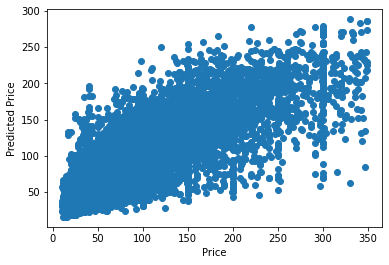

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

n_neighbors = 13
knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X, y)

y_pred = knn.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

### Model test: KNN

----- EVALUATION ON TEST SET ------
RMSE 40.01082908325537
MAE 26.631763673588768
R^2:  0.6472415992564602


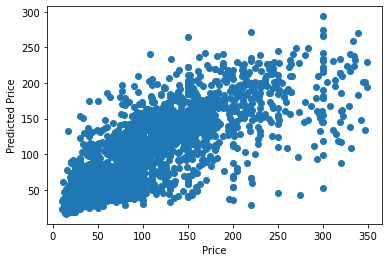

In [ ]:
y_pred_test = knn.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.show()

## Linear regression train

----- EVALUATION ON TRAIN SET ------
RMSE 48.47841191680346
MAE 33.75671290490344
R^2:  0.4811745776012244


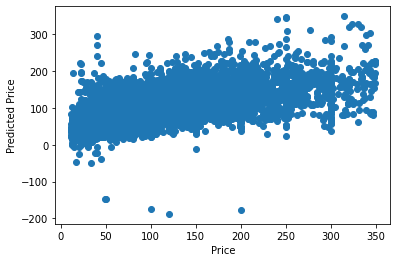

In [ ]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()

lr.fit(X, y)


y_pred = lr.predict(X)



print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Linear regression test

----- EVALUATION ON TEST SET ------
RMSE 48.295807047550184
MAE 33.807655082756504
R^2:  0.4860260368066902


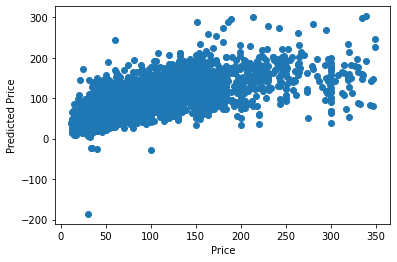

In [ ]:
y_pred_test = lr.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Random forest

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


----- EVALUATION ON TRAIN SET ------
RMSE 14.195708967220202
MAE 9.318388196568609
R^2:  0.9555124331656516
OOB SCORE 0.6769954145428797


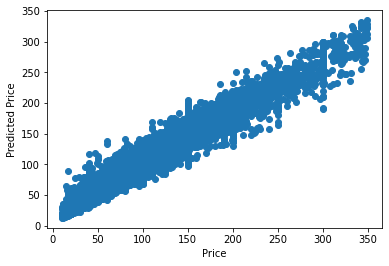

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)
# Train the model on training data
rf.fit(X, y)

## predict training set
y_pred = rf.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))
print('OOB SCORE', rf.oob_score_)



plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Random forest test

----- EVALUATION ON TEST SET ------
RMSE 38.33011741316219
MAE 25.13218209960368
R^2:  0.676255377914286


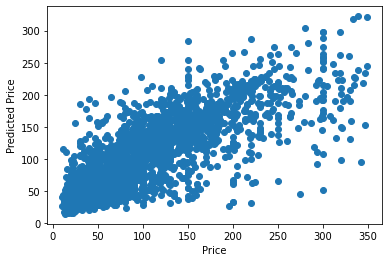

In [ ]:
y_pred_test = rf.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()